In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import random
import shutil

import imutils
import cv2

from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,\
 Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

## Functions used in this notebook

In [14]:
def crop_images(images, add_pixels_value=0):
  '''fn identifies all "extreme" points of an image and crops a 
  rectangular cut based on the extreme points. Code adapted from pyimagesearch'''
  cropped = []
  # load the images, convert to greyscale and blur slightly
  for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    # thresholds image then perform a series of erosions and 
    # dilations to remove small regions of noise
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
      cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # extract extreme points
    # extLeft (West) is the X-axis min
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    # extRight (East) X-axis max
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    # extTop Y-axis max (North)
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    # extBot Y-axis min (South)
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # cropping step
    ADD_PIXELS = add_pixels_value
    new_img = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,\
                  extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    cropped.append(new_img)

  return np.array(cropped)

def model_stats():
  '''fn will return accuracy metrics of current instantiated "history" model'''
  accuracy = np.array(history.history['accuracy']).mean()
  loss = np.array(history.history['loss']).mean()
  val_acc = np.array(history.history['val_accuracy']).mean()
  val_loss = np.array(history.history['val_loss']).mean()
  return (f"Loss: {loss:.2f}, Accuracy: {accuracy:.2f}, Val Loss: {val_loss:.2f}, Val Accuracy: {val_acc:.2f})")

## Preprocessing

Create directories I will need to place the cropped images into to call upon later.

In [15]:
path = '/content/drive/MyDrive/Colab/capstone/data/archive-2'
os.chdir(path)

In [ ]:
# code commented out after execution to prevent remaking directories
# test_folder = '/content/drive/MyDrive/Colab/capstone/data/archive-2/cropped_test'

# os.makedirs(os.path.join(test_folder, 'glioma'))
# os.makedirs(os.path.join(test_folder, 'meningioma'))
# os.makedirs(os.path.join(test_folder, 'notumor'))
# os.makedirs(os.path.join(test_folder, 'pituitary'))

In [ ]:
# train_folder = '/content/drive/MyDrive/Colab/capstone/data/archive-2/cropped_train'

# os.makedirs(os.path.join(train_folder, 'glioma'))
# os.makedirs(os.path.join(train_folder, 'meningioma'))
# os.makedirs(os.path.join(train_folder, 'notumor'))
# os.makedirs(os.path.join(train_folder, 'pituitary'))

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Colab/capstone/data/archive-2/Testing/glioma/Te-glTr_0000.jpg')
image = cv2.resize(image, dsize = (224, 224), interpolation=cv2.INTER_CUBIC)
# INTER_CUBIC: This uses bicubic interpolation for resizing the image. 
# While resizing and interpolating new pixels, this method acts on the 4×4 
# neighboring pixels of the image. It then takes the weights average of the 
# 16 pixels to create the new interpolated pixel.
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)


thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
  cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# extract extreme points
# extLeft (West) is the X-axis min
extLeft = tuple(c[c[:, :, 0].argmin()][0])
# extRight (East) X-axis max
extRight = tuple(c[c[:, :, 0].argmax()][0])
# extTop Y-axis max (North)
extTop = tuple(c[c[:, :, 1].argmin()][0])
# extBot Y-axis min (South)
extBot = tuple(c[c[:, :, 1].argmax()][0])

# cropping step
ADD_PIXELS = 0
new_img = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,\
              extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

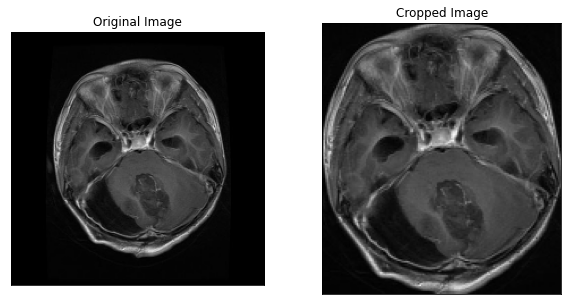

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (10,5))

ax[0].imshow(image)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Original Image')

ax[1].imshow(new_img)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Cropped Image')

plt.show()

In [ ]:
# # changing my code from the binary classification model to be more efficient:

# subfolders = ['glioma', 'meningioma', 'notumor', 'pituitary']
# folderPath = '/content/drive/MyDrive/Colab/capstone/data/archive-2/'
# image_size = 224

# # iterate through each folder:
# for directory in ['Testing', 'Training']:
#   # set current directory, this should set the directory to Testing or Training
#   current_path = os.path.join(folderPath, directory)
#   # iterate through the list of subfolders:
#   for subfolder in subfolders:
#     # set current path to the subfolder (ie Testing/glioma)
#     subfolder_path = os.path.join(current_path, subfolder)
#     # for all image files in the subfolder:
#     for image_file in os.listdir(subfolder_path):
#       # targets each image file specifically
#       image_path = os.path.join(subfolder_path, image_file)
#       # declare the image file as an object/load it in
#       image = cv2.imread(image_path)
#       # crop the image with my custom function
#       cropped_image = crop_images([image])[0]
#       # set destination file to export the cropped image
#       # the destination is "cropped_testing" or "cropped_training so I need to set directory.lower()
#       destination = os.path.join(folderPath, 'cropped_' + directory.lower() ,subfolder)
#       # set the save path for the actual file
#       save_path = os.path.join(destination, image_file)
#       cv2.imwrite(save_path, cropped_image)
      

In [16]:
datagen = ImageDataGenerator(rescale=1/255)

In [17]:
train_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive-2/cropped_training/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['glioma', 'meningioma', 'notumor', 'pituitary'],
    class_mode='categorical',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 5712 images belonging to 4 classes.


In [18]:
test_data = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Colab/capstone/data/archive-2/cropped_testing/',
    target_size = (224, 224),
    color_mode='rgb',
    classes=['glioma', 'meningioma', 'notumor', 'pituitary'],
    class_mode='categorical',
    batch_size= 32,
    shuffle=True,
    seed=33
)

Found 1311 images belonging to 4 classes.


## Basemodel

In [ ]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten(name='flatten'))

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience = 5)

history = model.fit(train_data,
                    batch_size = 16,
                    validation_data = test_data,
                    epochs=1000,
                    callbacks=[es],
                    verbose=0)

In [ ]:
model_stats()

'Loss: 1.39, Accuracy: 0.28, Val Loss: 1.38, Val Accuracy: 0.30)'

## VGG transfer learning model

Settings are taken from binary classification model and tweaked for multiclassification.

In [19]:
# Import VGG16
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# freezing the base layers as to not overwrite
for layer in vgg.layers:
    layer.trainable = False

In [25]:
model = Sequential()
model.add(vgg)
# Adding a final layer like one we'd find in the model.
# The original model uses maxpooling 2D, trying average instead.
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 5)

In [26]:
history = model.fit(train_data,
                    batch_size = 16,
                    validation_data = test_data,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)

In [27]:
model_stats()

'Loss: 0.18, Accuracy: 0.93, Val Loss: 0.29, Val Accuracy: 0.89)'

In [29]:
accuracy_dict= {'dropout_prob': [], 'test_accuracy': []}

In [21]:
model = Sequential()
model.add(vgg)
# Adding a final layer like one we'd find in the model.
# The original model uses maxpooling 2D, trying average instead.
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
history = model.fit(train_data,
                    batch_size = 16,
                    validation_data = test_data,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)

In [ ]:
# Optimizing model parameters:

# list of optimizers to use from the available list taken from the Keras webiste
# optimizers = ['Adam', 'Adadelta', 'Adagrad', 'Adamax']
# optimizers took over 8 hours and Colab terminated the session.

# create a for loop to iterate through the list and test each param

# for optimizer in optimizers:
#   model = Sequential()
#   model.add(vgg)
#   # Adding a final layer like one we'd find in the model.
#   # The original model uses maxpooling 2D, trying average instead.
#   model.add(GlobalAveragePooling2D())
#   model.add(Dense(1024, activation='relu'))
#   model.add(Dense(1024, activation='relu'))
#   model.add(Dense(512, activation='relu'))
#   model.add(Dense(4, activation='softmax'))

#   model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
#                 loss='categorical_crossentropy', 
#                 metrics =['accuracy'])
#   es = EarlyStopping(monitor = 'val_loss', patience = 5)
#   # in order to set the learning rate of each optimizer, I'll have to instantiate each one 
#   optimizer_ins = getattr(tf.optimizers, optimizer)(learning_rate=0.0001)
#   # 
#                     batch_size = 16,
#                     validation_data = test_data,
#                     epochs = 1000,
#                     callbacks = [es],
#                     verbose = 0)
#   accuracy_dict['optimizer'].append(optimizer)
#   accuracy_dict['test_accuracy'].append(history.history['val_accuracy'][-1])

In [32]:
dropouts = [0.7, 0.5, 0.3]

for drop in dropouts:
  model = Sequential()
  model.add(vgg)

  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(drop)) # dropout parameter here
  model.add(Dense(4, activation='softmax'))

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy', 
                metrics =['accuracy'])
  es = EarlyStopping(monitor = 'val_loss', patience = 5)

  history = model.fit(train_data,
                    batch_size = 8,
                    validation_data = test_data,
                    epochs = 30,
                    callbacks = [es],
                    verbose = 0)
  accuracy_dict['dropout_prob'].append(drop)
  accuracy_dict['test_accuracy'].append(history.history['val_accuracy'][-1])

In [34]:
dropout_df = pd.DataFrame(accuracy_dict)

In [35]:
dropout_df

,dropout_prob,test_accuracy
0,0.7,0.905416
1,0.5,0.922960
2,0.3,0.932876


In [36]:
# Recompiling final model for export
model = Sequential()
model.add(vgg)

model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 5)

history = model.fit(train_data,
                  batch_size = 8,
                  validation_data = test_data,
                  epochs = 30,
                  callbacks = [es],
                  verbose = 0)

In [37]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_11  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_44 (Dense)            (None, 1024)              525312    
                                                                 
 dense_45 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_46 (Dense)            (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                     

In [38]:
model.save('/content/drive/MyDrive/Colab/capstone/models/vgg_xfer_multi')

In [41]:
loaded_model = tf.saved_model.load('/content/drive/MyDrive/Colab/capstone/models/vgg_xfer_multi')

In [50]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_11  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_44 (Dense)            (None, 1024)              525312    
                                                                 
 dense_45 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_46 (Dense)            (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                     

In [52]:
model.save('/content/drive/MyDrive/Colab/capstone/models/vgg_multi_h5/model.h5')

In [53]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab/capstone/models/vgg_multi_h5/model.h5')

In [54]:
loaded_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_11  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_44 (Dense)            (None, 1024)              525312    
                                                                 
 dense_45 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_46 (Dense)            (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                     

Final model has an accuracy of 93%